In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import json
import requests
import pandas as pd
from metrics import calculate_metric


### Create sample df


In [2]:
# df = pd.read_csv('../data/data.csv')

# christmas_sample = ['tt1430607', 'tt13381368', 'tt0104940',  'tt13320784', 'tt13356246', 'tt6269192', 'tt0319343', 'tt0314331', 'tt0107688', 'tt3626180',  'tt1519929', 'tt1327788', 'tt2990140']
# space_sample = ['tt1182345', 'tt1446714', 'tt1454468', 'tt0448134', 'tt0816692', 'tt0119116', 'tt0119177', 'tt0118884', 'tt0796366', 'tt1408101', 'tt0134847', 'tt2015381', 'tt3659388', 'tt3896198', 'tt0379786', 'tt3748528','tt21157976', 'tt15609374', 'tt12483148', 'tt5597272', 'tt14191506', 'tt7794734', 'tt11771702', 'tt9782756', 'tt13347662', 'tt4372340', 'tt7918178', 'tt3351386', 'tt6024606', 'tt4859370', 'tt12787166', 'tt15663664']
# teen_sample = ['tt0435679', 'tt2582846', 'tt2582496', 'tt2962876', 'tt1714206', 'tt0910970', 'tt1282140', 'tt0377092', 'tt2205697', 'tt0398286', 'tt0109830', 'tt1798709', 'tt0467406', 'tt2980648', 'tt1659337', 'tt1010048', 'tt0817177', 'tt0181875', 'tt0338013', 'tt0338013', 'tt1924396', 'tt0414387', 'tt0332280', 'tt0462610', 'tt1838737', 'tt3846674', 'tt6472976', 'tt1638002', 'tt2674426', 'tt0147800', 'tt1022603', 'tt3783958', 'tt2194499']

# relevant_ids = christmas_sample + space_sample + teen_sample;

# filtered_df = df[~df['tconst'].isin(relevant_ids)]
# relevant_sample = df[df['tconst'].isin(relevant_ids)]

# sample = filtered_df.sample(n=222)
# sample.append(relevant_sample)

# sample["genres"] = sample["genres"].str.split(',')
# sample["directors"] = sample["directors"].str.split(',')
# sample.to_csv('../data/sample_data.csv', index=False)
# sample.to_json('../data/sample_data.json' orient='records')


### Evaluation


In [3]:
CHRISTMAS_QRELS_FILE = "../qrels_files/christmas_movies.txt"
ROMANCE_TEEN_QRELS_FILE = "../qrels_files/romance_teen.txt"
SPACE_QRELS_FILE = "../qrels_files/space_movies.txt"

CHRISTMAS_BASIC_QUERY_URL = "http://localhost:8983/solr/imdb_movies/select?defType=dismax&fl=*%20score&indent=true&q.op=OR&q=christmas%5E2%20santa%5E2%20snow%20elf%20rodolf%20festive%20claus%20merry%20holliday%20%22candy%20cane%22%20%22christmas%20tree%22%20eve%20advent&qf=originalTitle%20primaryTitle%20synopsis&tie=0.1&rows=300"
CHRISTMAS_BOOSTED_QUERY_URL = "http://localhost:8983/solr/imdb_movies/select?bq=primaryTitle%3A%20christmas%5E5.0%20synopsis%3Achristmas%5E3&defType=dismax&fl=score%20*&indent=true&q.op=OR&q=christmas%5E2%20santa%5E2%20snow%20elf%20rodolf%20festive%20claus%20merry%20holliday%20%22candy%20cane%22%20%22christmas%20tree%22%20eve%20advent&qf=originalTitle%5E1.5%20primaryTitle%5E1.5%20synopsis%5E2&tie=0.1&rows=300"

SPACE_BASIC_QUERY_URL = "http://localhost:8983/solr/imdb_movies/select?defType=dismax&fl=score%20*&indent=true&q.op=OR&q=space%20astronaut%20galaxy%20planets&qf=originalTitle%20primaryTitle%20synopsis&tie=0.1&rows=300"
SPACE_BOOSTED_QUERY_URL = "http://localhost:8983/solr/imdb_movies/select?bq=genres%3Asci-fi%5E3.0%20synopsis%3Astars&defType=dismax&fl=score%20*&indent=true&q.op=OR&q=space%20astronaut%20galaxy%20planets&qf=originalTitle%5E1.5%20primaryTitle%5E1.5%20synopsis%5E2&tie=0.1&rows=300"

ROMANCE_BASIC_TEEN_QUERY_URL = "http://localhost:8983/solr/imdb_movies/select?defType=dismax&fl=*%20score&indent=true&q.op=OR&q=romance%20teen%20crush%20heart-break%20%22in%20love%22%20high-school%20college%20friends%20friendship%20campus%20gossip%20passion%20attraction&qf=originalTitle%20primaryTitle%20synopsis&tie=0.1&rows=300"
ROMANCE_BOOSTED_TEEN_QUERY_URL = "http://localhost:8983/solr/imdb_movies/select?bq=genres%3Adrama%20genres%3Aromance%20synopsis%3Acrush%5E2.0&defType=dismax&indent=true&q.op=OR&q=romance%20teen%5E3.0%20crush%20heart-break%5E3.0%20%5C%5C%5C%22in%20love%5C%5C%5C%22%5E2.0%20high-school%5E2.0%20college%20friends%20friendship%20campus%20gossip%20passion%20attraction&qf=originalTitle%5E1.5%20primaryTitle%5E1.5%20synopsis%5E4&tie=0.1"


In [4]:
info = {
    "christmas_movies": {
        "basic_query_url": CHRISTMAS_BASIC_QUERY_URL,
        "boosted_query_url": CHRISTMAS_BOOSTED_QUERY_URL,
        "qrels_file": CHRISTMAS_QRELS_FILE,
    },
    "space_movies": {
        "basic_query_url": SPACE_BASIC_QUERY_URL,
        "boosted_query_url": SPACE_BOOSTED_QUERY_URL,
        "qrels_file": SPACE_QRELS_FILE,
    },
    "romance_teen_movies": {
        "basic_query_url": ROMANCE_BASIC_TEEN_QUERY_URL,
        "boosted_query_url": ROMANCE_BOOSTED_TEEN_QUERY_URL,
        "qrels_file": ROMANCE_TEEN_QRELS_FILE,
    },
}

/var/folders/04/05jdn06x4bd37twbh8c046nr0000gn/T/ipykernel_4828/713389509.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(df.to_latex())
/var/folders/04/05jdn06x4bd37twbh8c046nr0000gn/T/ipykernel_4828/713389509.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(df.to_latex())
/var/folders/04/05jdn06x4bd37twbh8c046nr0000gn/T/ipykernel_4828/713389509.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implemen

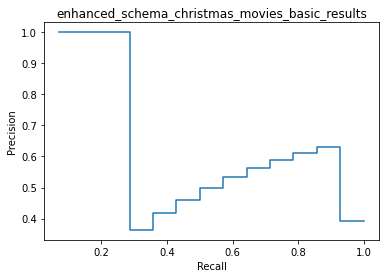

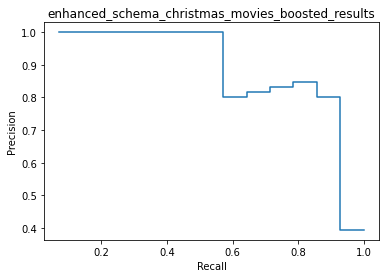

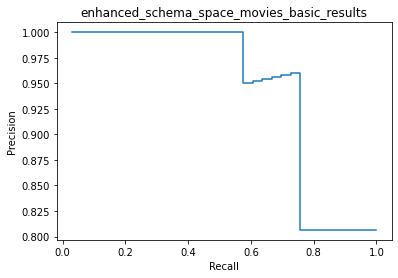

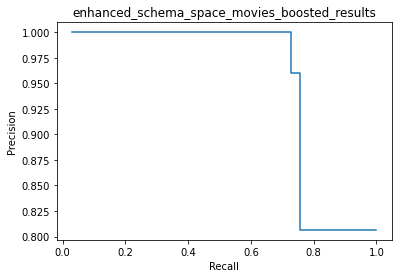

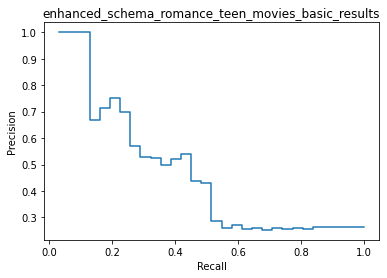

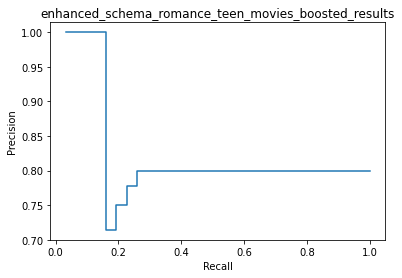

In [5]:
for movie_type, paths in info.items():
    # Read qrels to extract relevant documents
    relevant = list(map(lambda el: el.strip(), open(paths['qrels_file']).readlines()))

    # Get query results from Solr instance
    basic_results = requests.get(paths['basic_query_url']).json()["response"]["docs"]
    boosted_results = requests.get(paths['boosted_query_url']).json()["response"]["docs"]
    

    # Define metrics to be calculated
    evaluation_metrics = {"ap": "Average Precision", "p10": "Precision at 10 (P@10)"}

    # Calculate all metrics and export results as LaTeX table
    df = pd.DataFrame(
        [["Metric", "Value"]]
        + [
            [evaluation_metrics[m], calculate_metric(m, basic_results, relevant)]
            for m in evaluation_metrics
        ]
        + [
            [evaluation_metrics[m], calculate_metric(m, boosted_results, relevant)]
            for m in evaluation_metrics
        ]
    )

    with open(f"../results/{movie_type}/schema_enhanced_results.tex", "w") as tf:
        tf.write(df.to_latex())

    results = [(basic_results, "basic_results"), (boosted_results, "boosted_results")]

    # PRECISION-RECALL CURVE
    # Calculate precision and recall values as we move down the ranked list
    for (result, type) in results:
        precision_values = [
            len([doc for doc in result[:idx] if doc["tconst"] in relevant]) / idx
            for idx, _ in enumerate(result, start=1)
        ]

        recall_values = [
            len([doc for doc in result[:idx] if doc["tconst"] in relevant]) / len(relevant)
            for idx, _ in enumerate(result, start=1)
        ]

        precision_recall_match = {k: v for k, v in zip(recall_values, precision_values)}

        # Extend recall_values to include traditional steps for a better curve (0.1, 0.2 ...)
        recall_values.extend([step for step in np.arange(0.1, 1.1, 0.1) if step not in recall_values])
        recall_values = sorted(set(recall_values))

        # Extend matching dict to include these new intermediate steps
        for idx, step in enumerate(recall_values):
            if step in precision_recall_match:
                continue

            if recall_values[idx - 1] in precision_recall_match:
                precision_recall_match[step] = precision_recall_match[recall_values[idx - 1]]
            else:
                precision_recall_match[step] = precision_recall_match[recall_values[idx + 1]]

        disp = PrecisionRecallDisplay([precision_recall_match.get(r) for r in recall_values], recall_values)
        disp.plot()
        plt.title(f"enhanced_schema_{movie_type}_{type}")
        plt.savefig(f"../results/{movie_type}/schema_enhanced_{type}_precision_recall.pdf")
